# DeepPoseKit Step 1 - Create an annotation set

In [1]:
import sys
import os
import numpy as np
import cv2
import h5py
import matplotlib.pyplot as plt
from deepposekit.io import VideoReader, DataGenerator, initialize_dataset
from deepposekit.annotate import KMeansSampler
import tqdm
import glob
import pandas as pd

from os.path import expanduser

c:\users\islam\anaconda3\envs\keras\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\islam\anaconda3\envs\keras\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\islam\anaconda3\envs\keras\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\users\islam\anaconda3\envs\keras\lib\site-packages\tensorflow\python\f

# A note on image resolutions

Currently DeepPoseKit only supports image resolutions that can be repeatedly divided by 2. For example, all of these values are valid image resolutions for either height or width:

In [2]:
exp = np.arange(1,12)
exp = 2**exp

print(1*exp)
print(3*exp)
print(5*exp)
print(7*exp)
print(11*exp)

[   2    4    8   16   32   64  128  256  512 1024 2048]
[   6   12   24   48   96  192  384  768 1536 3072 6144]
[   10    20    40    80   160   320   640  1280  2560  5120 10240]
[   14    28    56   112   224   448   896  1792  3584  7168 14336]
[   22    44    88   176   352   704  1408  2816  5632 11264 22528]


Images that do not match these resolutions must be manually resized, cropped, or padded. We are working to add automated image size adjustments.

# Open a video
The `VideoReader` class allows you to load in single video frames or batches of frames from nearly any video format.

In [35]:
path_to_data = "deepposekit-data/datasets/"
videos = glob.glob(os.path.join(path_to_data,  'horse/*.mp4'))
videos

['deepposekit-data/datasets/horse\\video_1.mp4',
 'deepposekit-data/datasets/horse\\video_1_1.mp4',
 'deepposekit-data/datasets/horse\\video_2.mp4',
 'deepposekit-data/datasets/horse\\video_3.mp4',
 'deepposekit-data/datasets/horse\\video_3_1.mp4']

In [36]:
reader = VideoReader(videos[4], gray=False)
print(len(reader))
frame = reader[0] # read a frame
reader.close()
frame.shape

3332


(1, 360, 640, 3)

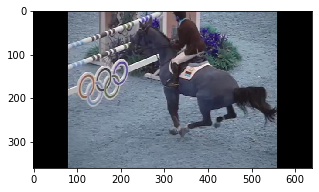

In [37]:
plt.figure(figsize=(5,5))
plt.imshow(frame[0,...])
plt.show()

# Sample video frames
This loads batches of 100 frames from the video, and then randomly samples frames from the batches to hold them in memory. You can use any method for sampling frames.

In [38]:
reader = VideoReader(videos[4], batch_size=100, gray=True)

randomly_sampled_frames = []
for idx in tqdm.tqdm(range(len(reader)-1)):
    batch = reader[idx]
    random_sample = batch[np.random.choice(batch.shape[0], 10, replace=False)]
    randomly_sampled_frames.append(random_sample)
reader.close()

randomly_sampled_frames = np.concatenate(randomly_sampled_frames)
randomly_sampled_frames.shape

100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:03<00:00, 10.89it/s]


(330, 360, 640, 1)

# Apply k-means to reduce correlation

This applies the k-means algorithm to the images using `KMeansSampler` to even out sampling across the distribution of images and reduce correlation within the annotation set.

In [39]:
kmeans = KMeansSampler(n_clusters=10, max_iter=1000, n_init=10, batch_size=100, verbose=True)
kmeans.fit(randomly_sampled_frames)

Init 1/10 with method: k-means++
Inertia for init 1/10: 58607873668.509857
Init 2/10 with method: k-means++
Inertia for init 2/10: 57429798802.325897
Init 3/10 with method: k-means++
Inertia for init 3/10: 57930168592.435226
Init 4/10 with method: k-means++
Inertia for init 4/10: 55070098697.592735
Init 5/10 with method: k-means++
Inertia for init 5/10: 57223813050.485565
Init 6/10 with method: k-means++
Inertia for init 6/10: 55997828347.254578
Init 7/10 with method: k-means++
Inertia for init 7/10: 58166344263.589783
Init 8/10 with method: k-means++
Inertia for init 8/10: 56018416492.003494
Init 9/10 with method: k-means++
Inertia for init 9/10: 56980585985.855309
Init 10/10 with method: k-means++
Inertia for init 10/10: 58328458328.410873
Minibatch iteration 1/4000: mean batch inertia: 181846174.626479, ewa inertia: 181846174.626479 
Minibatch iteration 2/4000: mean batch inertia: 205188557.803473, ewa inertia: 195950333.645811 
Minibatch iteration 3/4000: mean batch inertia: 191220

KMeansSampler(batch_size=100, compute_labels=True, init='k-means++',
              init_size=None, max_iter=1000, max_no_improvement=10,
              n_clusters=10, n_init=10, random_state=None,
              reassignment_ratio=0.01, tol=0.0, verbose=True)

c:\users\islam\anaconda3\envs\keras\lib\site-packages\sklearn\utils\validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)


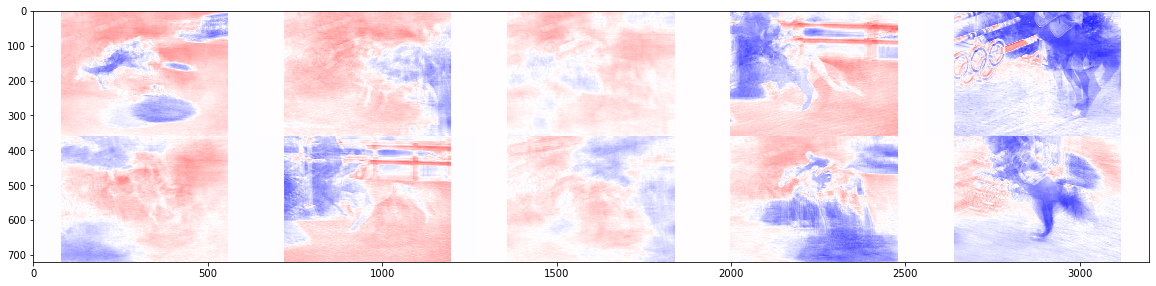

In [40]:
kmeans.plot_centers(n_rows=2)
plt.show()

In [41]:
kmeans_sampled_frames, kmeans_cluster_labels = kmeans.sample_data(randomly_sampled_frames, n_samples_per_label=10)
kmeans_sampled_frames.shape

Computing label assignment and total inertia


c:\users\islam\anaconda3\envs\keras\lib\site-packages\sklearn\utils\validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)


Computing label assignment and total inertia


(96, 360, 640, 1)

# Define a keypoints skeleton file

In [42]:
skeleton = pd.read_csv(os.path.join(path_to_data, 'horse/skeleton.csv'))
skeleton

,name,parent,swap
0,nose_tip,NaN,NaN
1,head_top,nose_tip,NaN
2,neck_low,head_top,NaN
3,behind,neck_low,NaN
4,legLeftFront_b0,NaN,legRightFront_b0
5,legLeftFront_b1,legLeftFront_b0,legRightFront_b1
6,legLeftFront_b2,legLeftFront_b1,legRightFront_b2
7,legLeftFront_b3,legLeftFront_b2,legRightFront_b3
8,legRightFront_b0,NaN,legLeftFront_b0
9,legRightFront_b1,legRightFront_b0,legLeftFront_b1


# Initialize a new data set for annotations

In [13]:
initialize_dataset?

In [43]:
initialize_dataset(
    images=kmeans_sampled_frames,
    datapath=os.path.join(path_to_data, 'horse/example_annotation_set.h5'),
    skeleton=os.path.join(path_to_data, 'horse/skeleton.csv'),
    overwrite=True # This overwrites the existing datapath
)

# Create a data generator

C:\Users\islam\AppData\Roaming\Python\Python36\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


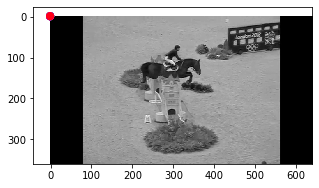

In [44]:
data_generator = DataGenerator(os.path.join(path_to_data, 'horse/example_annotation_set.h5'), mode="full")

image, keypoints = data_generator[0]

plt.figure(figsize=(5,5))
image = image[0] if image.shape[-1] is 3 else image[0, ..., 0]
cmap = None if image.shape[-1] is 3 else 'gray'
plt.imshow(image, cmap=cmap, interpolation='none')
for idx, jdx in enumerate(data_generator.graph):
    if jdx > -1:
        plt.plot(
            [keypoints[0, idx, 0], keypoints[0, jdx, 0]],
            [keypoints[0, idx, 1], keypoints[0, jdx, 1]],
            'r-'
        )
plt.scatter(keypoints[0, :, 0], keypoints[0, :, 1], c=np.arange(data_generator.keypoints_shape[0]), s=50, cmap=plt.cm.hsv, zorder=3)

plt.show()